# **Preprocess Data and Create Labels and Features**


In [2]:
#bismillah
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [6]:
DATA_PATH = os.path.join('Dataset_4')

actions = np.array(['Kanan','Kiri','Maju','Mundur','NA','Stop'])
sequence_length = 20

In [7]:

label_map = {label: num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(
                sequence), "{}-norm.npy".format(frame_num)))
 
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(210, 20, 108)

In [8]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(147, 20, 108)
(63, 20, 108)
(147, 6)
(63, 6)


# **Build and Train LSTM Neural Network**


In [12]:
# Path ke folder untuk menyimpan model
model_folder = 'model_keras'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Cari angka terakhir di file yang sudah ada
existing_files = [f for f in os.listdir(model_folder) if f.startswith('model_dataset_') and f.endswith('.keras')]
existing_numbers = [int(f.split('_')[-1].split('.')[0]) for f in existing_files]
next_number = max(existing_numbers) + 1 if existing_numbers else 1

# Nama file checkpoint baru
checkpoint_filename = os.path.join(model_folder, f"model_dataset_{next_number}.keras")
print(f"Checkpoint akan disimpan sebagai: {checkpoint_filename}")

# Setup ModelCheckpoint
checkpoint = ModelCheckpoint(
    checkpoint_filename, 
    monitor='categorical_accuracy', 
    verbose=1, 
    mode='max', 
    save_best_only=True, 
    save_weights_only=False, 
    save_freq='epoch'
)

Checkpoint akan disimpan sebagai: model_keras\model_dataset_1.keras


In [13]:
model = Sequential()

model.add(TimeDistributed(
    Dense(units=128, activation='tanh'), input_shape=(20, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 20, 128)        │        13,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,262 (813.52 KB)

 Trainable params: 208,262 (813.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.2238 - loss: 1.7597
Epoch 1: categorical_accuracy improved from -inf to 0.28571, saving model to model_keras\model_dataset_1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - categorical_accuracy: 0.2341 - loss: 1.7552 - val_categorical_accuracy: 0.6190 - val_loss: 1.5803
Epoch 2/45
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3750 - loss: 1.6932
Epoch 2: categorical_accuracy improved from 0.28571 to 0.42857, saving model to model_keras\model_dataset_1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3994 - loss: 1.6133 - val_categorical_accuracy: 0.6825 - val_loss: 1.4314
Epoch 3/45
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4375 - loss: 1.5279
Epoch 3: categorical_accuracy improved from 0.42857 to 0.49660, saving model to model_keras\model_dataset_1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.4832 - loss: 1.4688 - val_categoric

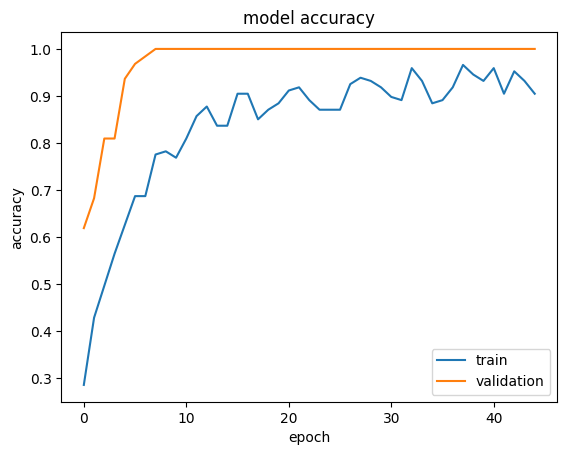

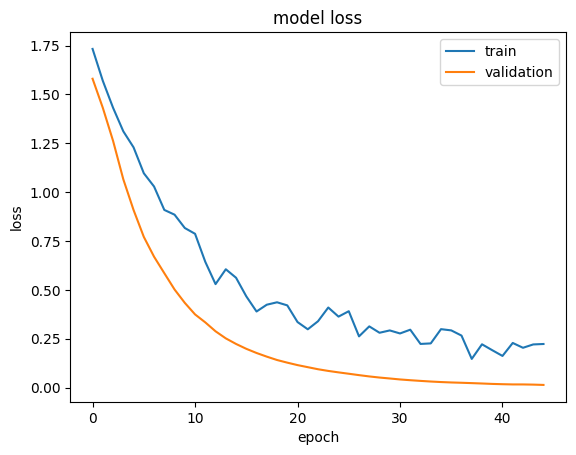

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 20, 128)        │        13,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,788 (2.38 MB)

 Trainable params: 208,262 (813.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,526 (1.59 MB)

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=45, callbacks=[
                        checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

model.summary()

In [624]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**


In [ ]:
# Path ke folder model
model_folder = 'model'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Cari angka terakhir di file yang sudah ada
existing_files = [f for f in os.listdir(model_folder) if f.startswith('model_dataset_') and f.endswith('.h5')]
existing_numbers = [int(f.split('_')[-1].split('.')[0]) for f in existing_files]
next_number = max(existing_numbers) + 1 if existing_numbers else 1

# Nama file baru
model_filename = os.path.join(model_folder, f"model_dataset_{next_number}.h5")
print(f"Model akan disimpan sebagai: {model_filename}")

# Simpan model
model.save(model_filename)

# Muat ulang model (jika perlu)
model.load_weights(model_filename)
print(f"Model telah disimpan dan dimuat ulang dari: {model_filename}")

Model akan disimpan sebagai: model\model_dataset_12.h5
Model telah disimpan dan dimuat ulang dari: model\model_dataset_12.h5


# **Evaluation using Confusion Matrix and Accuracy**


In [16]:
yhat = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


In [17]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

Kiri
Kiri


In [18]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [19]:
from sklearn.metrics import classification_report

report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

       Kanan       1.00      1.00      1.00        12
        Kiri       1.00      1.00      1.00        17
        Maju       1.00      1.00      1.00         6
      Mundur       1.00      1.00      1.00        16
          NA       1.00      1.00      1.00         6
        Stop       1.00      1.00      1.00         6

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [20]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

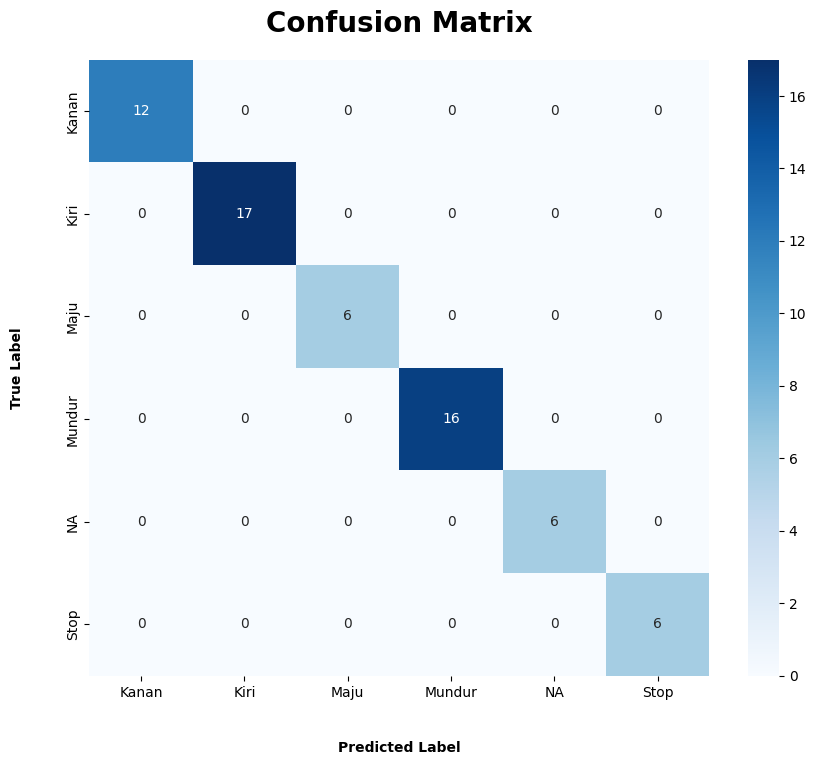

In [21]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d',
                      cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [22]:
from sklearn.metrics import precision_recall_fscore_support

metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i]))
                      for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: Kanan
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kiri
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Maju
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Mundur
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: NA
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Stop
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kanan
Accuracy: 1.0

Class: Kiri
Accuracy: 1.0

Class: Maju
Accuracy: 1.0

Class: Mundur
Accuracy: 1.0

Class: NA
Accuracy: 1.0

Class: Stop
Accuracy: 1.0

